## LSA

Latent Semantic Analysis (LSA) is a theory and method for extracting and representing the contextual-usage meaning of words by statistical computations applied to a large corpus of text.

LSA is an information retrieval technique which analyzes and identifies the pattern in unstructured collection of text and the relationship between them.

LSA is an unsupervised way of uncovering synonyms in a collection of documents.

In [1]:
import pandas as pd

df = pd.read_csv('Reviews.csv')

In [2]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [38]:
df.shape

(568454, 10)

## TF-IDF

TFIDF is an information retrieval technique that weighs a term’s frequency (TF) and its inverse document frequency (IDF). Each word has its respective TF and IDF score. The product of the TF and IDF scores of a word is called the TFIDF weight of that word.

Put simply, the higher the TFIDF score (weight), the rarer the word and vice versa.

In [39]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
tfidf.fit(df['Text'])

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [40]:
X = tfidf.transform(df['Text'])

In [41]:
df['Text'][1]

'Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".'

In reference to the above sentence, we can check out tf-idf scores for a few words.

In [7]:
print([X[1, tfidf.vocabulary_['peanuts']]])

[0.37995462060339136]


In [8]:
print([X[1, tfidf.vocabulary_['jumbo']]])

[0.530965343023095]


In [9]:
print([X[1, tfidf.vocabulary_['error']]])

[0.2302711360436964]


Among these three words, "peanut", "jumbo" and "error", tf-idf gives the highest weight to "jumbo". This indicates that "jumbo" is a much rarer word than "peanut" and "error". This is how to use the tf-idf to indicate the importance of words or terms inside a collection of documents.

## Text Classification

To classify sentiment, we remove neutral score 3, then group score 4 and 5 to positive (1), and score 1 and 2 to negative (0).  

In [3]:
import numpy as np

df.dropna(inplace=True)
df[df['Score'] != 3]
df['Positivity'] = np.where(df['Score'] > 3, 1, 0)
cols = ['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time', 'Summary']
df.drop(cols, axis=1, inplace=True)
df.head()

,Text,Positivity
0,I have bought several of the Vitality canned d...,1
1,Product arrived labeled as Jumbo Salted Peanut...,0
2,This is a confection that has been around a fe...,1
3,If you are looking for the secret ingredient i...,0
4,Great taffy at a great price. There was a wid...,1


In [4]:
df.groupby('Positivity').size()

Positivity
0    124645
1    443766
dtype: int64

### Train test split

In [5]:
X = df.Text
y = df.Positivity

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0)

In [7]:
print("Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_train),
                                                                             (len(X_train[y_train == 0]) / (len(X_train)*1.))*100,
                                                                            (len(X_train[y_train == 1]) / (len(X_train)*1.))*100))

Train set has total 426308 entries with 21.91% negative, 78.09% positive


In [8]:
print("Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive".format(len(X_test),
                                                                             (len(X_test[y_test == 0]) / (len(X_test)*1.))*100,
                                                                            (len(X_test[y_test == 1]) / (len(X_test)*1.))*100))

Test set has total 142103 entries with 21.99% negative, 78.01% positive


In [9]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

In [19]:
def accuracy_summary(pipeline, X_train, y_train, X_test, y_test):
    sentiment_fit = pipeline.fit(X_train, y_train)
    y_pred = sentiment_fit.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    return accuracy

In [22]:
cv = CountVectorizer()
rf = RandomForestClassifier(class_weight="balanced")
n_features = np.arange(10000,30001,10000)

def nfeature_accuracy_checker(vectorizer=cv, n_features=n_features, stop_words=None, ngram_range=(1, 1), classifier=rf):
    result = []
    print(classifier)
    print("\n")
    for n in n_features:
        vectorizer.set_params(stop_words=stop_words, max_features=n, ngram_range=ngram_range)
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', classifier)
        ])
        print("Test result for {} features".format(n))
        nfeature_accuracy = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,nfeature_accuracy))
    return result

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer()

In [25]:
print("Result for trigram with stop words (Tfidf)\n")
feature_result_tgt = nfeature_accuracy_checker(vectorizer=tfidf,ngram_range=(1, 3))

Result for trigram with stop words (Tfidf)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)


Test result for 10000 features
accuracy score: 90.50%
Test result for 20000 features
accuracy score: 90.44%
Test result for 30000 features
accuracy score: 90.63%


Before we are done here, we should sheck the classification report.

In [36]:
from sklearn.metrics import classification_report

cv = CountVectorizer(max_features=30000,ngram_range=(1, 3))
pipeline = Pipeline([
        ('vectorizer', cv),
        ('classifier', rf)
    ])
sentiment_fit = pipeline.fit(X_train, y_train)
y_pred = sentiment_fit.predict(X_test)

print(classification_report(y_test, y_pred, target_names=['negative','positive']))

             precision    recall  f1-score   support

   negative       0.82      0.73      0.78     31250
   positive       0.93      0.96      0.94    110853

avg / total       0.90      0.91      0.90    142103



## Chi2 Feature Selection

In [26]:
from sklearn.feature_selection import chi2

tfidf = TfidfVectorizer(max_features=30000,ngram_range=(1, 3))
X_tfidf = tfidf.fit_transform(df.Text)
y = df.Positivity
chi2score = chi2(X_tfidf, y)[0]

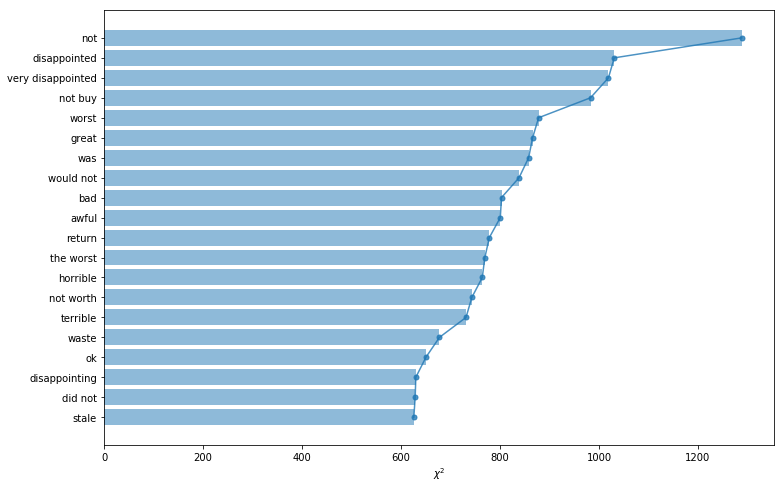

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(12,8))
scores = list(zip(tfidf.get_feature_names(), chi2score))
chi2 = sorted(scores, key=lambda x:x[1])
topchi2 = list(zip(*chi2[-20:]))
x = range(len(topchi2[1]))
labels = topchi2[0]
plt.barh(x,topchi2[1], align='center', alpha=0.5)
plt.plot(topchi2[1], x, '-o', markersize=5, alpha=0.8)
plt.yticks(x, labels)
plt.xlabel('$\chi^2$')
plt.show();